In [1]:
%matplotlib inline
%load_ext autor

In [2]:
import ete3
from Bio import Phylo
from io import StringIO

import numpy as np

In [233]:
def GSC_ete3(my_tree, weight=0):
    """
    A super simple implementation using the ete3 data structure. 
    And it checks out as far as I'm concerned, but probably needs some work around the edges.
    
    One ideological flaw that I see with the method, however, is this:
    test_tree = ete3.Tree('(((A:20, B:0):30,C:50):30, D:80);') 
    Node "B" should get zero weight as if it's not there?
    
    For the implementation, I should have a very short wrapper that checks the tree structure 
    for errors and then checks the output for consistency/expectation. Also (probably) removes
    the weights for internal nodes since these are just place-holders and need to be removed.
    """
    my_tree.add_features(weight=weight)
    if len(my_tree.get_children()) == 0:
        return
    elif len(my_tree.get_children())==2:
        l_child = my_tree.children[0]
        r_child = my_tree.children[1]
        l_ds = np.sum([i.dist for i in l_child.traverse()])
        r_ds = np.sum([i.dist for i in r_child.traverse()])
        total = l_ds + r_ds
        if total != 0:
            l_push = my_tree.weight * (l_ds/total)
            r_push = my_tree.weight * (r_ds/total)
        else:
            l_push = my_tree.weight/2.
            r_push = my_tree.weight/2.
        my_tree = GSC_ete3(l_child, l_push+l_child.dist)
        my_tree = GSC_ete3(r_child, r_push+r_child.dist)
    else:
        print('Error, tree does not appear to be bifurcating')
        return
    return

def normalize_GSC_ete3(my_tree):
    """
    This makes these numbers a *bit* more meaningful (imho) and this scaling alters some relative 
    relationships on non-ultrametric trees (slightly up-weighting sequences closer to the root
    compared to the base-line method. I think of it as a "% independence" metric.
    
    If trees are ultrametric, this should just re-scale without altering relationshps between leaves.
    """
    for leaf in my_tree.get_leaves():
        leaf.weight = leaf.weight/my_tree.get_distance(leaf)
    return

In [236]:
test_tree = ete3.Tree('(((A:20, B:0):30,C:50):30, D:80);')
GSC_ete3(test_tree)

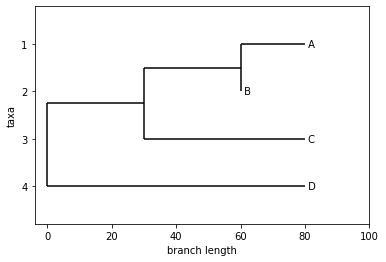

In [237]:
Phylo.draw(Phylo.read(StringIO(test_tree.write()), format='newick'), show_confidence=False)

In [238]:
for i in test_tree.get_leaves():
    print(i.name, i.weight)
print(np.sum([i.weight for i in test_tree.get_leaves()]))
print(np.sum([i.dist for i in test_tree.traverse()]))

A 65.0
B 0.0
C 65.0
D 80.0
210.0
210.0


In [239]:
normalize_GSC_ete3(test_tree)
for i in test_tree.get_leaves():
    print(i.name, i.weight)
print(np.sum([i.weight for i in test_tree.get_leaves()]))
print(np.sum([i.dist for i in test_tree.traverse()]))

A 0.8125
B 0.0
C 0.8125
D 1.0
2.625
210.0


# Comparing implementations

In [133]:
from Bio import Phylo
import weighting_methods

In [164]:
phylo_tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick',\
                  'newick', rooted=True)
phylo_weights_dict = weighting_methods.calc_GSC_weights(phylo_tree)


218 ms ± 7.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [165]:
ete3_tree = ete3.Tree('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick')
GSC_ete3(ete3_tree)

60.2 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [136]:
phylo_weights = []
ete3_weights = []
for term in phylo_tree.get_terminals():
    phylo_weights.append(phylo_weights_dict[term])
    ete3_weights.append(ete3_tree.get_leaves_by_name(term.name)[0].weight)

In [137]:
np.max([a-b for (a,b) in list(zip(phylo_weights, ete3_weights))])

2.220446049250313e-16

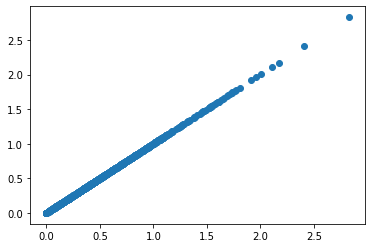

In [138]:
fig, ax = plt.subplots()
ax.scatter(phylo_weights, ete3_weights)

In [173]:
print(np.sum([i.weight for i in ete3_tree.get_leaves()]))
print(np.sum([i.dist for i in ete3_tree.traverse()]))

511.990423436
511.990423436


# ACL method...

I'm increasingly hard-pressed to see a purpose behind this method, at least for "raw" trees where tips are non-contemporaneous. This just makes most leaves roughly zero and gives a ton of weight to leaves that are close to the root. Which makes sense if you're trying to estimate the root but that's rarely the purpose of any methods that I can think of.

I think it might have some use/purpose on ultrametric trees (but this is of course it's own complicated and error-prone model). 

In [267]:
def vcv_recursive(my_tree, vcv_matrix, finished):
    leaves = len(my_tree.get_leaves())
    #if not set(my_tree.get_leaves()).issubset(set(finished)):
    vcv_matrix[len(finished):len(finished)+leaves,\
               len(finished):len(finished)+leaves] += my_tree.dist
    if len(my_tree.children) == 2:
        vcv_matrix, finished = vcv_recursive(my_tree.children[0], vcv_matrix, finished)
        vcv_matrix, finished = vcv_recursive(my_tree.children[1], vcv_matrix, finished)
    elif len(my_tree.children) == 0:
        finished.append(my_tree)
    return vcv_matrix, finished

In [315]:
test_tree = ete3.Tree('(((A:20, B:20):30,C:50):30, D:80);')
# test_tree = ete3.Tree('(((A:20, B:20):30,(E:40, F:40):10):30, D:80);')
test_tree = ete3.Tree('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick')
initial_matrix = np.zeros((len(test_tree.get_leaves()), len(test_tree.get_leaves())))
vcv_matrix, finished = vcv_recursive(test_tree, initial_matrix, [])

In [307]:
# vcv_matrix

array([[80., 60., 30.,  0.],
       [60., 80., 30.,  0.],
       [30., 30., 80.,  0.],
       [ 0.,  0.,  0., 80.]])

In [316]:
# Phylo.draw(Phylo.read(StringIO(test_tree.write()), format='newick'), show_confidence=False)

In [317]:
inv_vcv_matrix = np.linalg.inv(vcv_matrix)                                                                                                                                                                 
inv_weights = inv_vcv_matrix.sum(axis=1)/inv_vcv_matrix.sum()

In [320]:
inv_weights, np.sum(inv_weights)

(array([0.0003072 , 0.00056066, 0.00111135, ..., 0.0138787 , 0.01024664,
        0.10472103]), 0.9999999951270815)

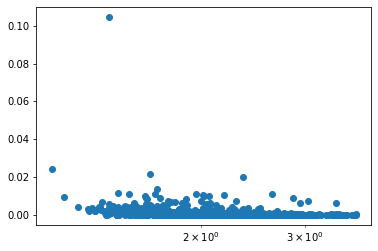

In [325]:
fig, ax = plt.subplots()
ax.semilogx([test_tree.get_distance(i) for i in test_tree.get_leaves()], inv_weights,\
        marker='o', linestyle='')

In [371]:
np.log(2)/0.164

4.226507198536251